In [25]:
from PIL import Image
import deeplocalizer as dl
import torch
from transformers import AutoImageProcessor, ResNetForImageClassification
import numpy as np
import os
np.random.seed(0)  # for reproducibility since I use df.sample() from numpy
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [26]:
# LOAD MODEL 
processor = AutoImageProcessor.from_pretrained("microsoft/resnet-34")
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-34")
model = model.to(DEVICE)

# AND DEFINE HOW TO USE IT
@torch.no_grad()
def resnet_forward(image_paths):
	images = [
		Image.open(f"./face_data/{p}").convert("RGB") for p in image_paths
	]
	inputs = processor(images, return_tensors="pt").to(DEVICE)
	outputs = model(**inputs)
	return outputs.logits

In [27]:
# LOAD FACE LOCALIZER TASK 
task, valid = dl.load_task("./face_data/task_face_localizer.parquet")

# DEFINE WHICH LAYERS TO TAKE ACTIVATIONS FROM
resnet_blocks = [layer for stage in model.resnet.encoder.stages for layer in stage.layers] # 16 layers

task.head()

,data,positive,validation
1000,celeba/2913.jpg,True,False
1001,celeba/3275.jpg,True,False
1002,celeba/775.jpg,True,False
1003,celeba/217.jpg,True,False
1004,celeba/1245.jpg,True,False


In [30]:
# COMPUTE ACTIVATIONS
# I've already computed them for you for the face task :)
localizer = dl.DeepLocalizer(task, resnet_blocks, resnet_forward).load_activations("./face_data/task_face_resnet34_acts.safetensors")

# rather compute yourself? Uncomment this line below.
# localizer = dl.DeepLocalizer(task, resnet_blocks, resnet_forward).compute_activations()

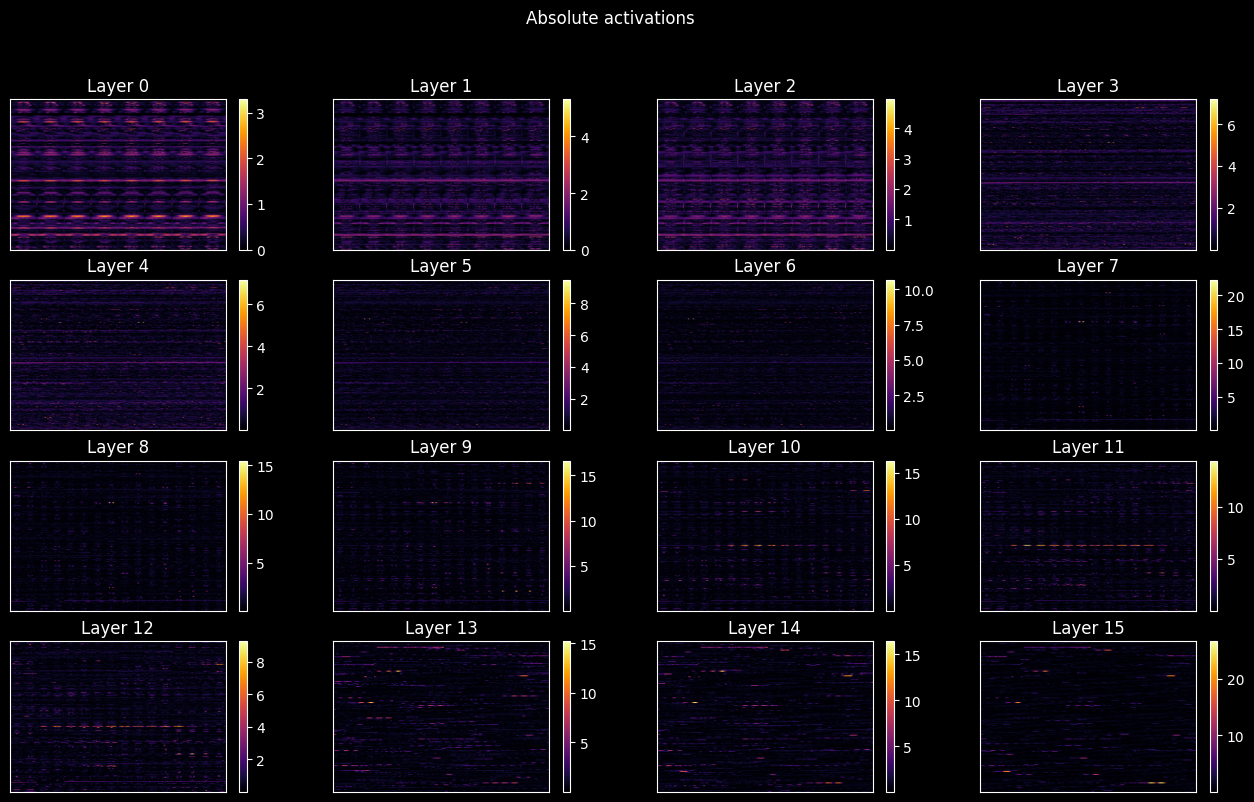

In [31]:
dl.visualize_activations(dl.overall_activation(localizer.activations), (4, 4), cmap="inferno")

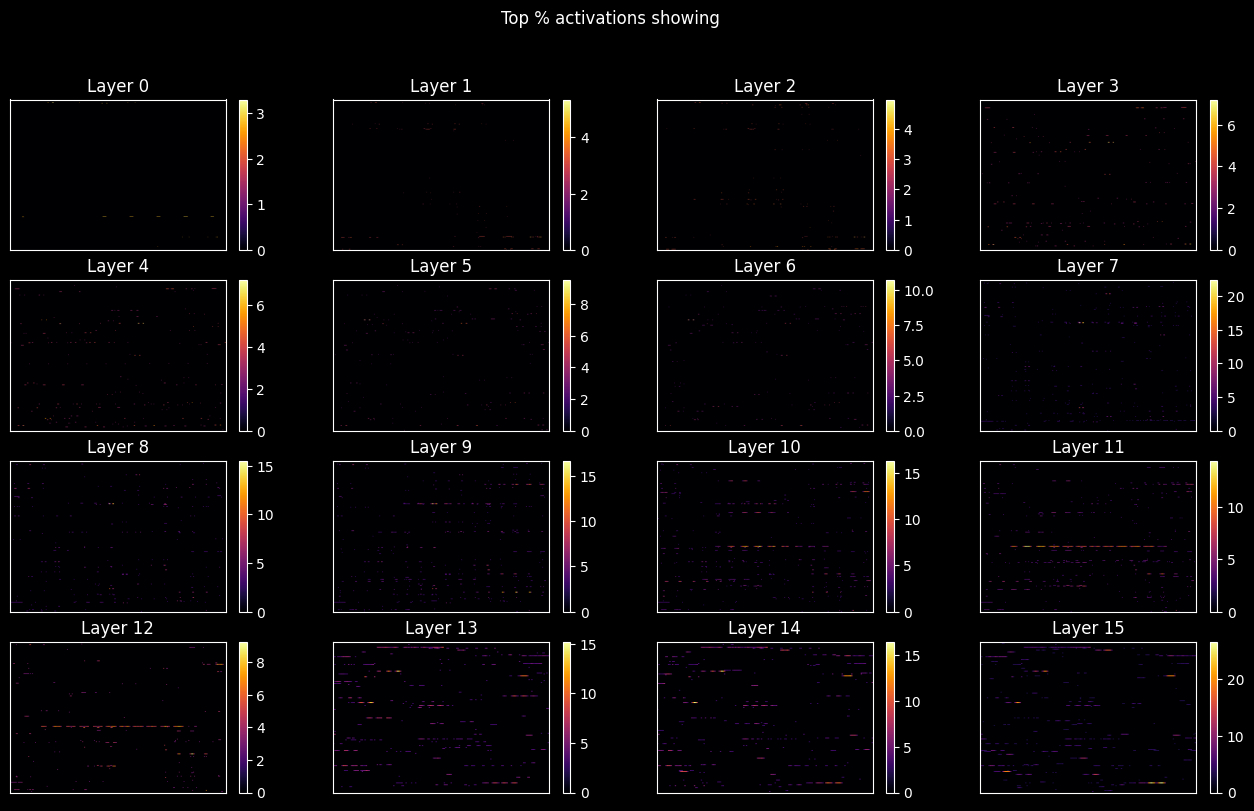

In [10]:
# COMPUTE TOP PERCENT ACTIVATIONS
top_percent = 0.5
top_idxs, top_values = localizer.top_percent_activations(top_percent)
dl.visualize_top_activations(top_idxs, top_values, localizer.activations)

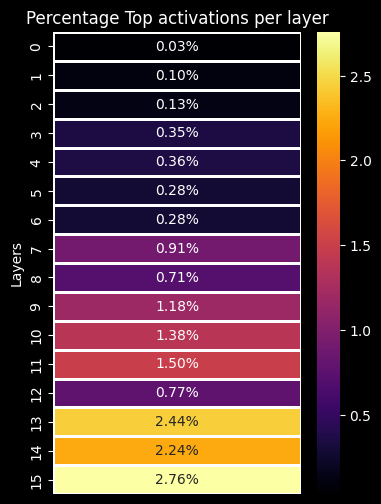

In [11]:
dl.visualize_top_per_layer(top_idxs, localizer.activations)

## Analysis

In [12]:
regular_task, regular_control = localizer.regular_model_forward(valid)

[DeepLocalizer] Computing Model Forward


100%|██████████| 32/32 [00:57<00:00,  1.80s/it]


In [13]:
ablated_task, ablated_control = localizer.ablate_model_forward(df=valid, ablate_activations=top_idxs)

perf_on_faces = dl.percent_label_stayed_same(
	before_preds=regular_task.argmax(-1), after_preds=ablated_task.argmax(-1)
)
print(
	f"[After Ablation] {perf_on_faces:.3f}% predictions stayed the same for face images"
)

perf_on_objects = dl.percent_label_stayed_same(
	before_preds=regular_control.argmax(-1),
	after_preds=ablated_control.argmax(-1),
)
print(
	f"[After Ablation] {perf_on_objects:.3f}% predictions stayed the same for object images"
)

[DeepLocalizer] Computing Model Forward ABLATED
[DeepLocalizer] Computing Model Forward


100%|██████████| 32/32 [01:08<00:00,  2.15s/it]

[After Ablation] 2.600% predictions stayed the same for face images
[After Ablation] 73.500% predictions stayed the same for object images


In [14]:
def kl_divergence(p, q):
    return (p * (p/q).log()).sum(-1, keepdims=True)

task_kl =  kl_divergence(ablated_task.softmax(-1), regular_task.softmax(-1)).mean().item()
control_kl =  kl_divergence(ablated_control.softmax(-1), regular_control.softmax(-1)).mean().item()

print("How do the prob distributions differ?")
print(f"Mean task KL Divergence between ablated and not: {task_kl:.6f}")
print(f"Mean control KL Divergence between ablated and not: {control_kl:.6f}")

How do the prob distributions differ?
Mean task KL Divergence between ablated and not: 3.114800
Mean control KL Divergence between ablated and not: 0.204265


Check which percentage best describes the face network

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("dark_background")

ps = [1, 0.5, 0.25, 0.125, 0.0625]
perf_task = []
perf_control = []

perf_kl_task = []
perf_kl_control = []

for p in ps:
	print(f"TRYING OUT TOP {p}%")
	top_indices, top_values = localizer.top_percent_activations(p)

	ablated_task, ablated_control = localizer.ablate_model_forward(
		df=valid, ablate_activations=top_indices
	)

	perf_on_faces = dl.percent_label_stayed_same(
		before_preds=regular_task.argmax(-1), after_preds=ablated_task.argmax(-1)
	)
	perf_on_objects = dl.percent_label_stayed_same(
		before_preds=regular_control.argmax(-1),
		after_preds=ablated_control.argmax(-1),
	)
	perf_task.append(perf_on_faces)
	perf_control.append(perf_on_objects)


	task_kl =  kl_divergence(ablated_task.softmax(-1), regular_task.softmax(-1)).mean().item()
	control_kl =  kl_divergence(ablated_control.softmax(-1), regular_control.softmax(-1)).mean().item()
	perf_kl_task.append(task_kl)
	perf_kl_control.append(control_kl)

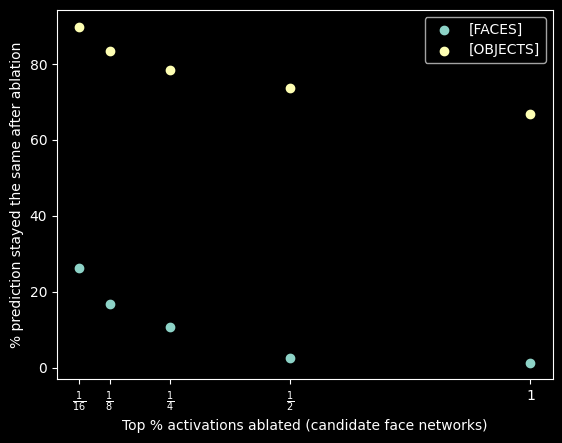

In [16]:
plt.scatter(ps, perf_task, label="[FACES]")
plt.scatter(ps, perf_control, label="[OBJECTS]")
frac = lambda n, d: r"$\frac{" + str(n) + "}" + "{" + str(d) + "}$"
plt.xticks(ps, labels=["$1$", frac(1, 2), frac(1, 4), frac(1, 8), frac(1, 16)])
plt.xlabel("Top % activations ablated (candidate face networks)")
plt.ylabel("% prediction stayed the same after ablation")
plt.legend()

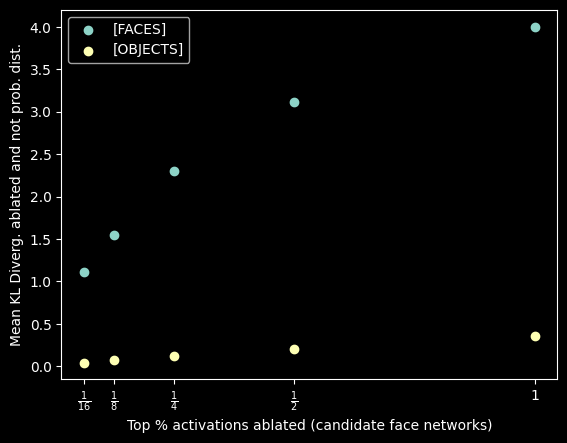

In [18]:
plt.scatter(ps, perf_kl_task, label="[FACES]")
plt.scatter(ps, perf_kl_control, label="[OBJECTS]")
plt.xticks(ps, labels=["$1$", frac(1, 2), frac(1, 4), frac(1, 8), frac(1, 16)])
plt.xlabel("Top % activations ablated (candidate face networks)")
plt.ylabel("Mean KL Diverg. ablated and not prob. dist.")
plt.legend()